## パッケージのインポート

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## データセットを読み込みと正規化

In [2]:
path = 'data/datasets'
sample_num = 7

mnist_train = MNIST(path, train=True, download=True, transform=None)
train_x = mnist_train.data
train_y = mnist_train.targets

train_x = train_x[train_y.flatten() == sample_num]
train_y = train_y[train_y.flatten() == sample_num]


## データセットの確認

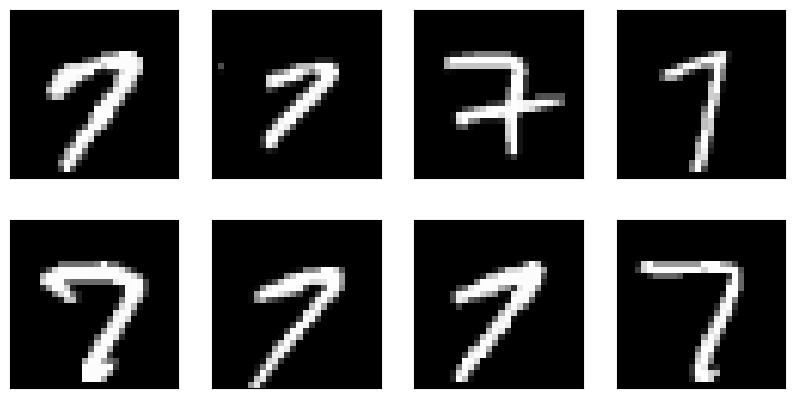

In [3]:
plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap='gray')
plt.show()

## データセット内の画像の正規化

In [4]:
train_x = train_x / 255 * 2 - 1

train_x = train_x.reshape(len(train_x), 1, 28, 28)

## 学習用データセットとテスト用データセットを作成

In [5]:
train_dataset = TensorDataset(train_x)

## バッチサイズ分ずつデータを読み出すData Loaderを作成

In [6]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1)

## 各パラメータの設定

In [7]:
epochs = 300  # 学習回数(=エポック数)
interval = 5  #途中段階の画像を表示する間隔
n_noise = 128  # 入力ノイズのサイズ
width = 28
height = 28
alpha = 0.01  #Leaky ReLUの負の領域での傾き DCGANの場合には0.01程度に変更

## ネットワークの構築

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense = nn.Linear(128, 7 * 7 * 128)
        self.bn1= nn.BatchNorm2d(128)
        self.convT1 = nn.ConvTranspose2d(128, 64, 5, 2, padding=2, output_padding=1)
        self.selu = nn.SELU()
        self.bn2 = nn.BatchNorm2d(64)
        self.convT2 = nn.ConvTranspose2d(64, 1, 5, 2, padding=2, output_padding=1)
        self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.dense(x)
        x = x.view([-1, 128, 7, 7])  # 1つ目の引数に-1を入れることで他の次元（引数）から１次元目に何を入れるかを予測することができる
        x = self.bn1(x)
        x = self.convT1(x)
        x = self.selu(x)
        x = self.bn2(x)
        x = self.convT2(x)
        x = self.tanh(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, padding=2),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, 2, padding=2),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

## CPUを使うのかGPUを使うのかを指定と確認

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

netG = Generator().to(device)
netD = Discriminator().to(device)

print("Device: {}".format(device))

Device: cuda


## 損失関数と最適化関数の定義

In [11]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

## ネットワークの構造の確認

In [12]:
print(netG)

Generator(
  (dense): Linear(in_features=128, out_features=6272, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (selu): SELU()
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (tanh): Tanh()
)


In [13]:
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


## 学習

  1%|▏         | 4/300 [00:04<05:39,  1.15s/it]

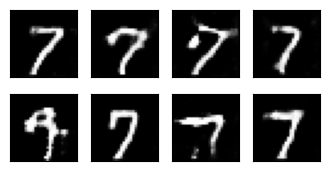

  3%|▎         | 9/300 [00:10<05:25,  1.12s/it]

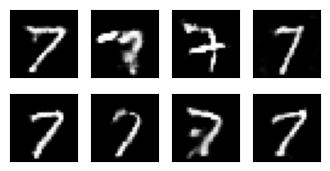

  5%|▍         | 14/300 [00:16<06:08,  1.29s/it]

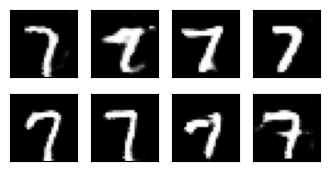

  6%|▋         | 19/300 [00:23<06:20,  1.36s/it]

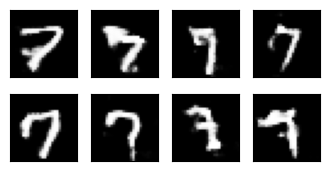

  8%|▊         | 24/300 [00:30<06:15,  1.36s/it]

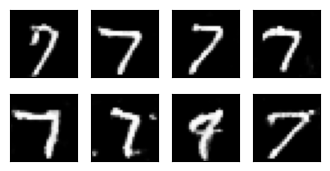

 10%|▉         | 29/300 [00:37<06:08,  1.36s/it]

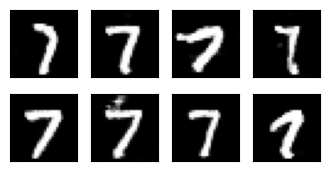

 11%|█▏        | 34/300 [00:44<05:59,  1.35s/it]

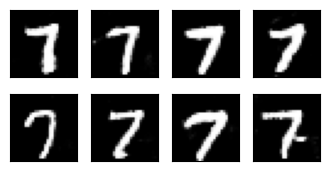

 13%|█▎        | 39/300 [00:50<05:51,  1.35s/it]

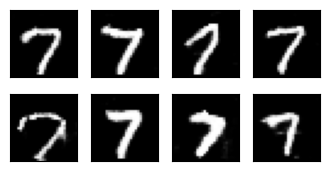

 15%|█▍        | 44/300 [00:57<05:43,  1.34s/it]

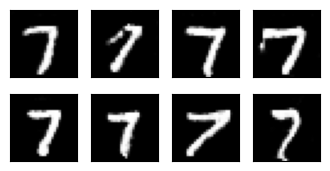

 16%|█▋        | 49/300 [01:04<05:34,  1.33s/it]

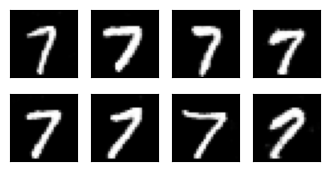

 18%|█▊        | 54/300 [01:10<05:29,  1.34s/it]

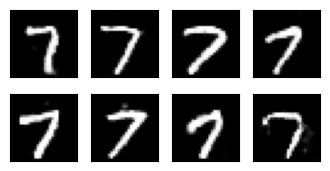

 20%|█▉        | 59/300 [01:17<05:22,  1.34s/it]

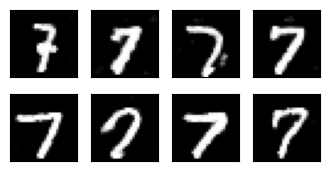

 21%|██▏       | 64/300 [01:24<05:18,  1.35s/it]

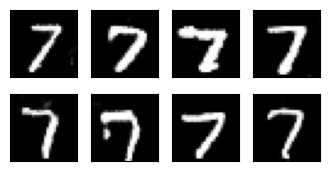

 23%|██▎       | 69/300 [01:30<04:30,  1.17s/it]

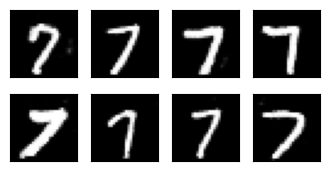

 25%|██▍       | 74/300 [01:35<04:14,  1.13s/it]

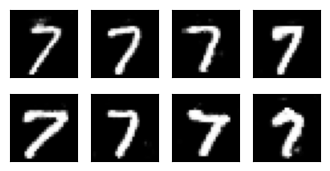

 26%|██▋       | 79/300 [01:41<04:09,  1.13s/it]

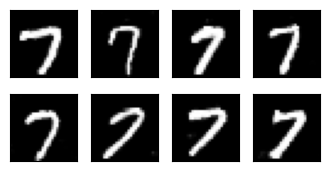

 28%|██▊       | 84/300 [01:47<04:01,  1.12s/it]

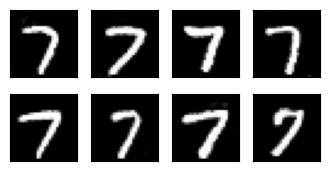

 30%|██▉       | 89/300 [01:52<03:49,  1.09s/it]

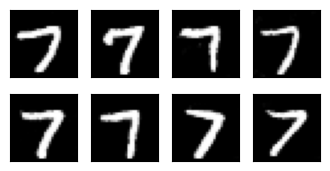

 31%|███▏      | 94/300 [01:58<03:44,  1.09s/it]

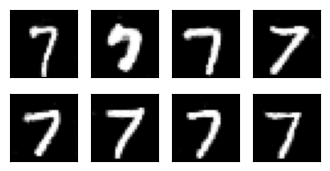

 33%|███▎      | 99/300 [02:03<03:44,  1.12s/it]

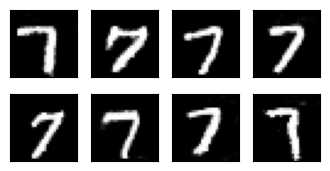

 35%|███▍      | 104/300 [02:09<03:40,  1.12s/it]

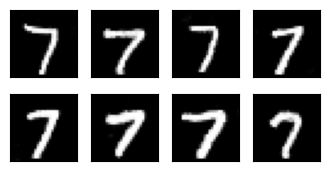

 36%|███▋      | 109/300 [02:14<03:31,  1.10s/it]

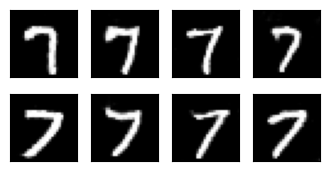

 38%|███▊      | 114/300 [02:20<03:24,  1.10s/it]

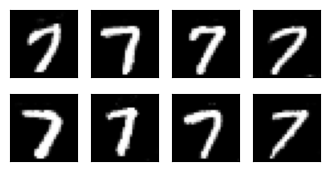

 40%|███▉      | 119/300 [02:25<03:10,  1.05s/it]

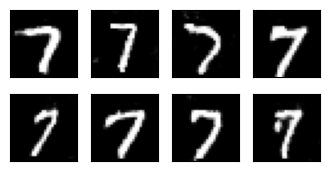

 41%|████▏     | 124/300 [02:30<02:35,  1.13it/s]

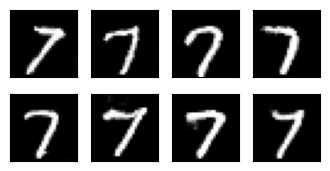

 43%|████▎     | 129/300 [02:34<02:23,  1.19it/s]

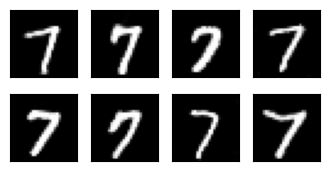

 45%|████▍     | 134/300 [02:38<02:19,  1.19it/s]

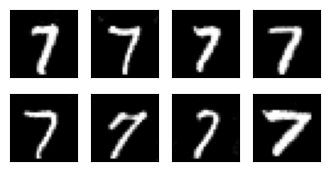

 46%|████▋     | 139/300 [02:42<02:09,  1.24it/s]

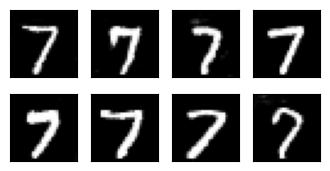

 48%|████▊     | 144/300 [02:46<02:06,  1.24it/s]

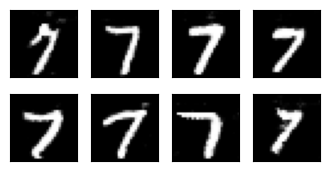

 50%|████▉     | 149/300 [02:50<02:02,  1.24it/s]

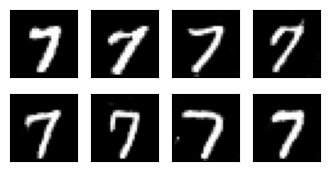

 51%|█████▏    | 154/300 [02:54<01:57,  1.24it/s]

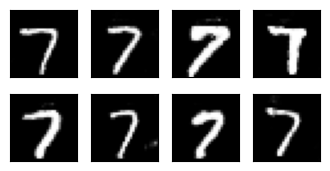

 53%|█████▎    | 159/300 [02:59<01:57,  1.20it/s]

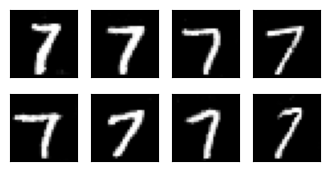

 55%|█████▍    | 164/300 [03:03<01:54,  1.19it/s]

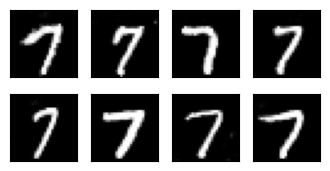

 56%|█████▋    | 169/300 [03:07<01:43,  1.27it/s]

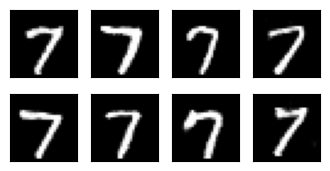

 58%|█████▊    | 174/300 [03:11<01:41,  1.24it/s]

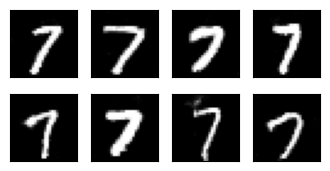

 60%|█████▉    | 179/300 [03:15<01:34,  1.27it/s]

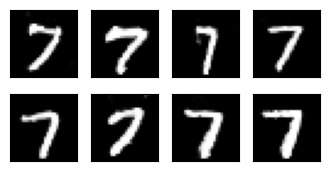

 61%|██████▏   | 184/300 [03:19<01:30,  1.29it/s]

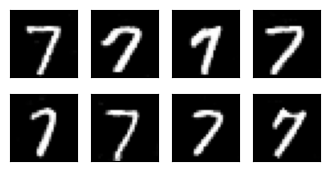

 63%|██████▎   | 189/300 [03:23<01:29,  1.24it/s]

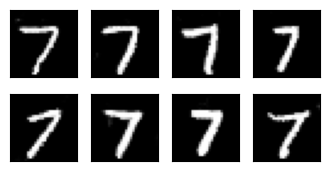

 65%|██████▍   | 194/300 [03:27<01:24,  1.25it/s]

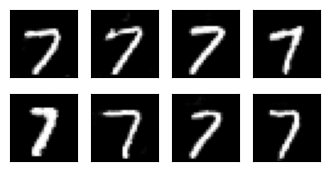

 66%|██████▋   | 199/300 [03:31<01:22,  1.23it/s]

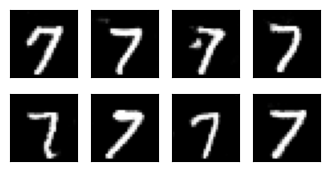

 68%|██████▊   | 204/300 [03:35<01:16,  1.25it/s]

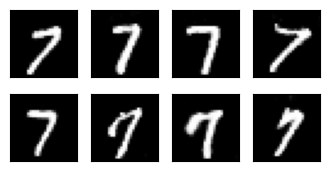

 70%|██████▉   | 209/300 [03:39<01:16,  1.20it/s]

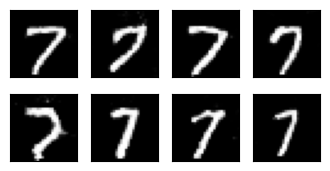

 71%|███████▏  | 214/300 [03:44<01:14,  1.16it/s]

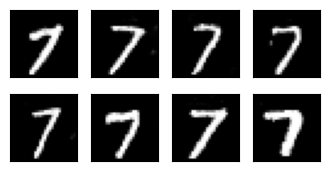

 73%|███████▎  | 219/300 [03:48<01:11,  1.14it/s]

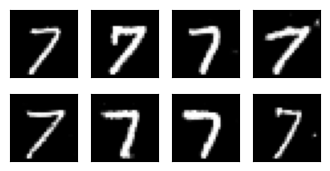

 75%|███████▍  | 224/300 [03:52<01:05,  1.16it/s]

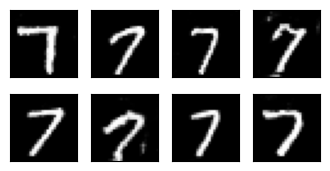

 76%|███████▋  | 229/300 [03:57<00:59,  1.18it/s]

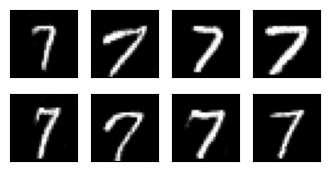

 78%|███████▊  | 234/300 [04:01<00:55,  1.18it/s]

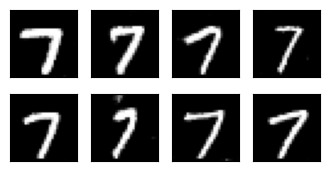

 80%|███████▉  | 239/300 [04:05<00:50,  1.20it/s]

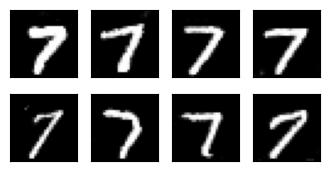

 81%|████████▏ | 244/300 [04:09<00:45,  1.22it/s]

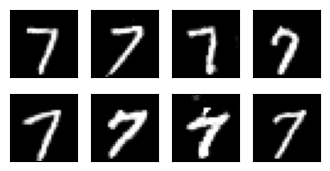

 83%|████████▎ | 249/300 [04:13<00:41,  1.23it/s]

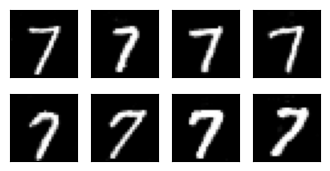

 85%|████████▍ | 254/300 [04:18<00:43,  1.06it/s]

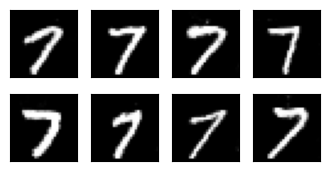

 86%|████████▋ | 259/300 [04:23<00:35,  1.14it/s]

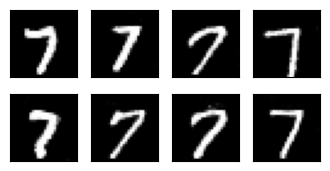

 88%|████████▊ | 264/300 [04:27<00:30,  1.18it/s]

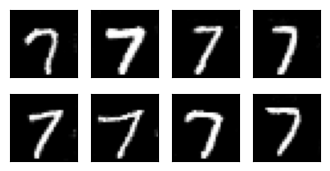

 90%|████████▉ | 269/300 [04:31<00:27,  1.15it/s]

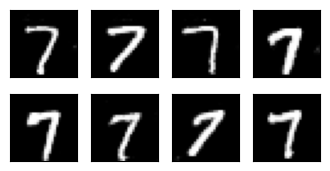

 91%|█████████▏| 274/300 [04:35<00:22,  1.18it/s]

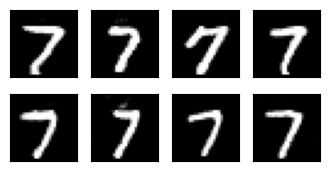

 93%|█████████▎| 279/300 [04:40<00:17,  1.20it/s]

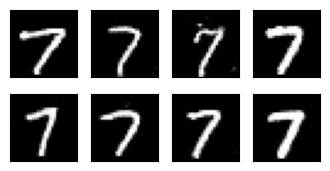

 95%|█████████▍| 284/300 [04:44<00:13,  1.14it/s]

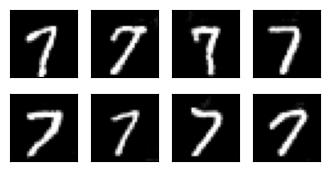

 96%|█████████▋| 289/300 [04:48<00:09,  1.15it/s]

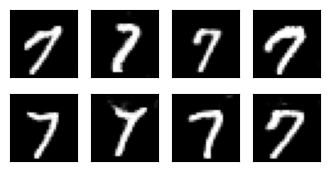

 98%|█████████▊| 294/300 [04:53<00:05,  1.19it/s]

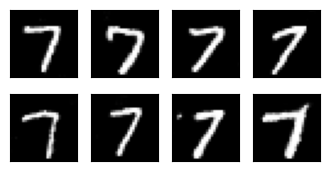

100%|█████████▉| 299/300 [04:57<00:00,  1.18it/s]

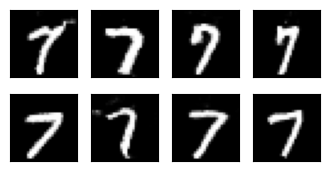

100%|██████████| 300/300 [04:58<00:00,  1.01it/s]


In [14]:
for epoch in tqdm(range(epochs)):
    for train_images in train_batch:
        netD.train()
        netG.eval()

        real_img = train_images[0]  # 本物画像を取得
        batch_size = real_img.shape[0] # バッチサイズの取得

        real_img = real_img.to(device)

        noise = torch.randn(batch_size, n_noise).to(device)
        fake_img = netG(noise)  # 偽物画像を取得

        real_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)


        # Discriminatorの学習
        optimizerD.zero_grad()

        output_img = netD(real_img)
        lossD_real = criterion(output_img, real_label)

        output_img = netD(fake_img.detach())
        lossD_fake = criterion(output_img, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Generatorの学習
        netG.train()
        netD.eval()

        optimizerG.zero_grad()

        noise = torch.randn(batch_size, n_noise).to(device)
        fake_img = netG(noise)
        output_img = netD(fake_img)
        lossG = criterion(output_img, real_label)
        lossG.backward()
        optimizerG.step()

    if ((epoch+1) % interval == 0):  # 五回に一回、学習状況を確認
        netG.eval()
        with torch.no_grad():  # with torch.no_grad():でくくることで、その下で定義したTensorの勾配計算をまとめて停止させることが可能
            noise = torch.randn(8, n_noise).to(device)
            generated_images = netG(noise)

        generated_images = generated_images.cpu().detach().numpy()

        plt.figure(figsize = (4, 2))
        for j in range(8):
            plt.subplot(2, 4, j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(generated_images[j].reshape(width, height), cmap = 'gray')
        plt.show()


## 生成された画像の表示

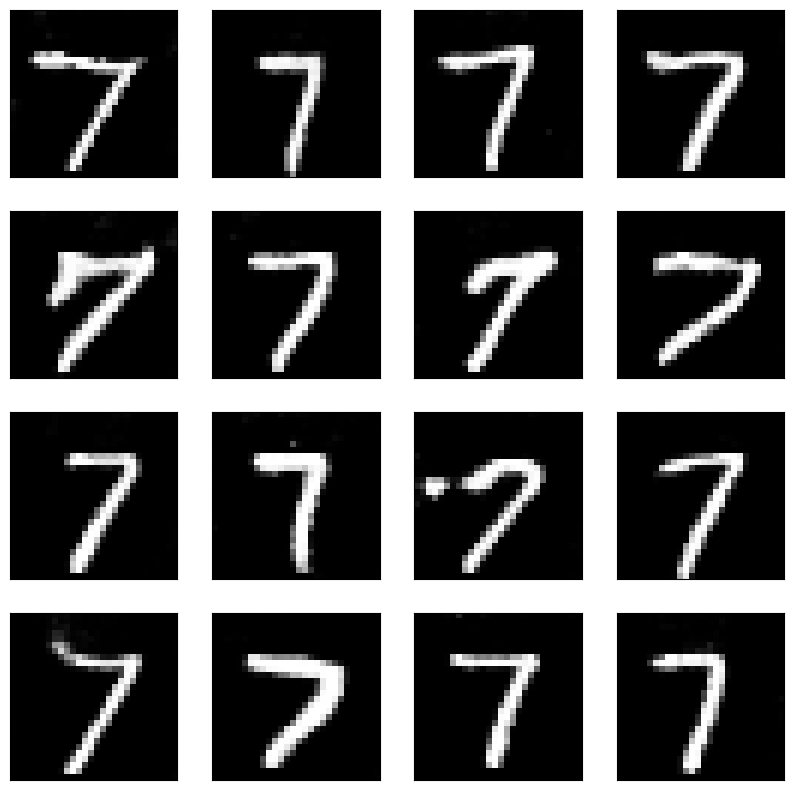

In [15]:
netG.eval()

with torch.no_grad():
    noise = torch.randn(16, n_noise).to(device)
    generated_images = netG(noise)

generated_images = generated_images.cpu().detach().numpy()

plt.figure(figsize = (10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i].reshape(width, height), cmap = 'gray')
plt.show()